In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from mrtoct import data

from matplotlib import pyplot as plt

transform = data.transform.DecodeExample()

def read_volume(path):
    return (tf.data.TFRecordDataset(path, 'GZIP')
            .map(transform)
            .make_one_shot_iterator()
            .get_next())

def mse(x, y):
    return ((x-y)**2).mean()

def mae(x, y):
    return np.abs(x - y).mean()

def psnr(x, y):
    max = np.iinfo(np.uint16).max
    mse = np.square(x - y).mean()
    
    return 20 * np.log10(max / np.sqrt(mse))

def unpad(x, shape):
    height = np.abs(shape[1] - x.shape[1]) / 2
    width = np.abs(shape[2] - x.shape[2]) / 2
    
    start_h = int(np.floor(height))
    start_w = int(np.floor(width))

    end_h = - int(np.ceil(height))
    end_w = - int(np.ceil(width))
    
    return x[:, start_h:end_h, start_w:end_w]

In [2]:
datadir = 'data/tfrecord/cleaned'
resultdir = '../mrtoct-results'

training = {
    'inputs': read_volume(os.path.join(datadir, 'mr.tfrecord')),
    'targets': read_volume(os.path.join(datadir, 'ct.tfrecord')),
    'unet': read_volume(os.path.join(resultdir, 'unet/mae2/training.tfrecord')),
    'pixtopix': read_volume(os.path.join(resultdir, 'pixtopix/lsquare-clean/training.tfrecord'))
}

validation = {
    'inputs': read_volume(os.path.join(datadir, 'validation-mr.tfrecord')),
    'targets': read_volume(os.path.join(datadir, 'validation-ct.tfrecord')),
    'unet': read_volume(os.path.join(resultdir, 'unet/mae2/validation.tfrecord')),
    'pixtopix': read_volume(os.path.join(resultdir, 'pixtopix/lsquare-clean/validation.tfrecord'))
}

session = tf.Session()


In [3]:
t = []
v = []

try:
    while True:
        t.append(session.run(list(training.values())))
except:
    pass

for i, vols in enumerate(t):
    for j, vol in enumerate(vols[2:]):
        vols[j+2] = unpad(vol, vols[1].shape) 

try:
    while True:
        v.append(session.run(list(validation.values())))
except:
    pass

for i, vols in enumerate(v):
    for j, vol in enumerate(vols[2:]):
        vols[j+2] = unpad(vol, vols[1].shape) 

In [4]:
mae_t = []
mse_t = []
psnr_t = []

for vols in t:
    mae_t.append([mae(vol, vols[1]) for vol in vols[2:]])
    mse_t.append([mse(vol, vols[1]) for vol in vols[2:]])
    psnr_t.append([psnr(vol, vols[1]) for vol in vols[2:]])
    
mae_t = np.array(mae_t)
mse_t = np.array(mse_t)
psnr_t = np.array(psnr_t)

In [5]:
pd.DataFrame(mae_t, columns=list(training.keys())[2:]).mean()

unet        90.463114
pixtopix    21.559681
dtype: float64

In [6]:
pd.DataFrame(mse_t, columns=list(training.keys())[2:]).mean()

unet        61852.709236
pixtopix     4209.866993
dtype: float64

In [7]:
pd.DataFrame(psnr_t, columns=list(training.keys())[2:]).mean()

unet        49.367599
pixtopix    60.379152
dtype: float64

In [8]:
mae_v = []
mse_v = []
psnr_v = []

for vols in v:
    mae_v.append([mae(vol, vols[1]) for vol in vols[2:]])
    mse_v.append([mse(vol, vols[1]) for vol in vols[2:]])
    psnr_v.append([psnr(vol, vols[1]) for vol in vols[2:]])
    
mae_v = np.array(mae_v)
mse_v = np.array(mse_v)
psnr_v = np.array(psnr_v)

In [9]:
pd.DataFrame(mae_v, columns=list(validation.keys())[2:]).mean()

unet        136.927919
pixtopix    112.726878
dtype: float64

In [10]:
pd.DataFrame(mse_v, columns=list(validation.keys())[2:]).mean()

unet        101943.090956
pixtopix     82173.027321
dtype: float64

In [11]:
pd.DataFrame(psnr_v, columns=list(validation.keys())[2:]).mean()

unet        46.765858
pixtopix    47.548011
dtype: float64

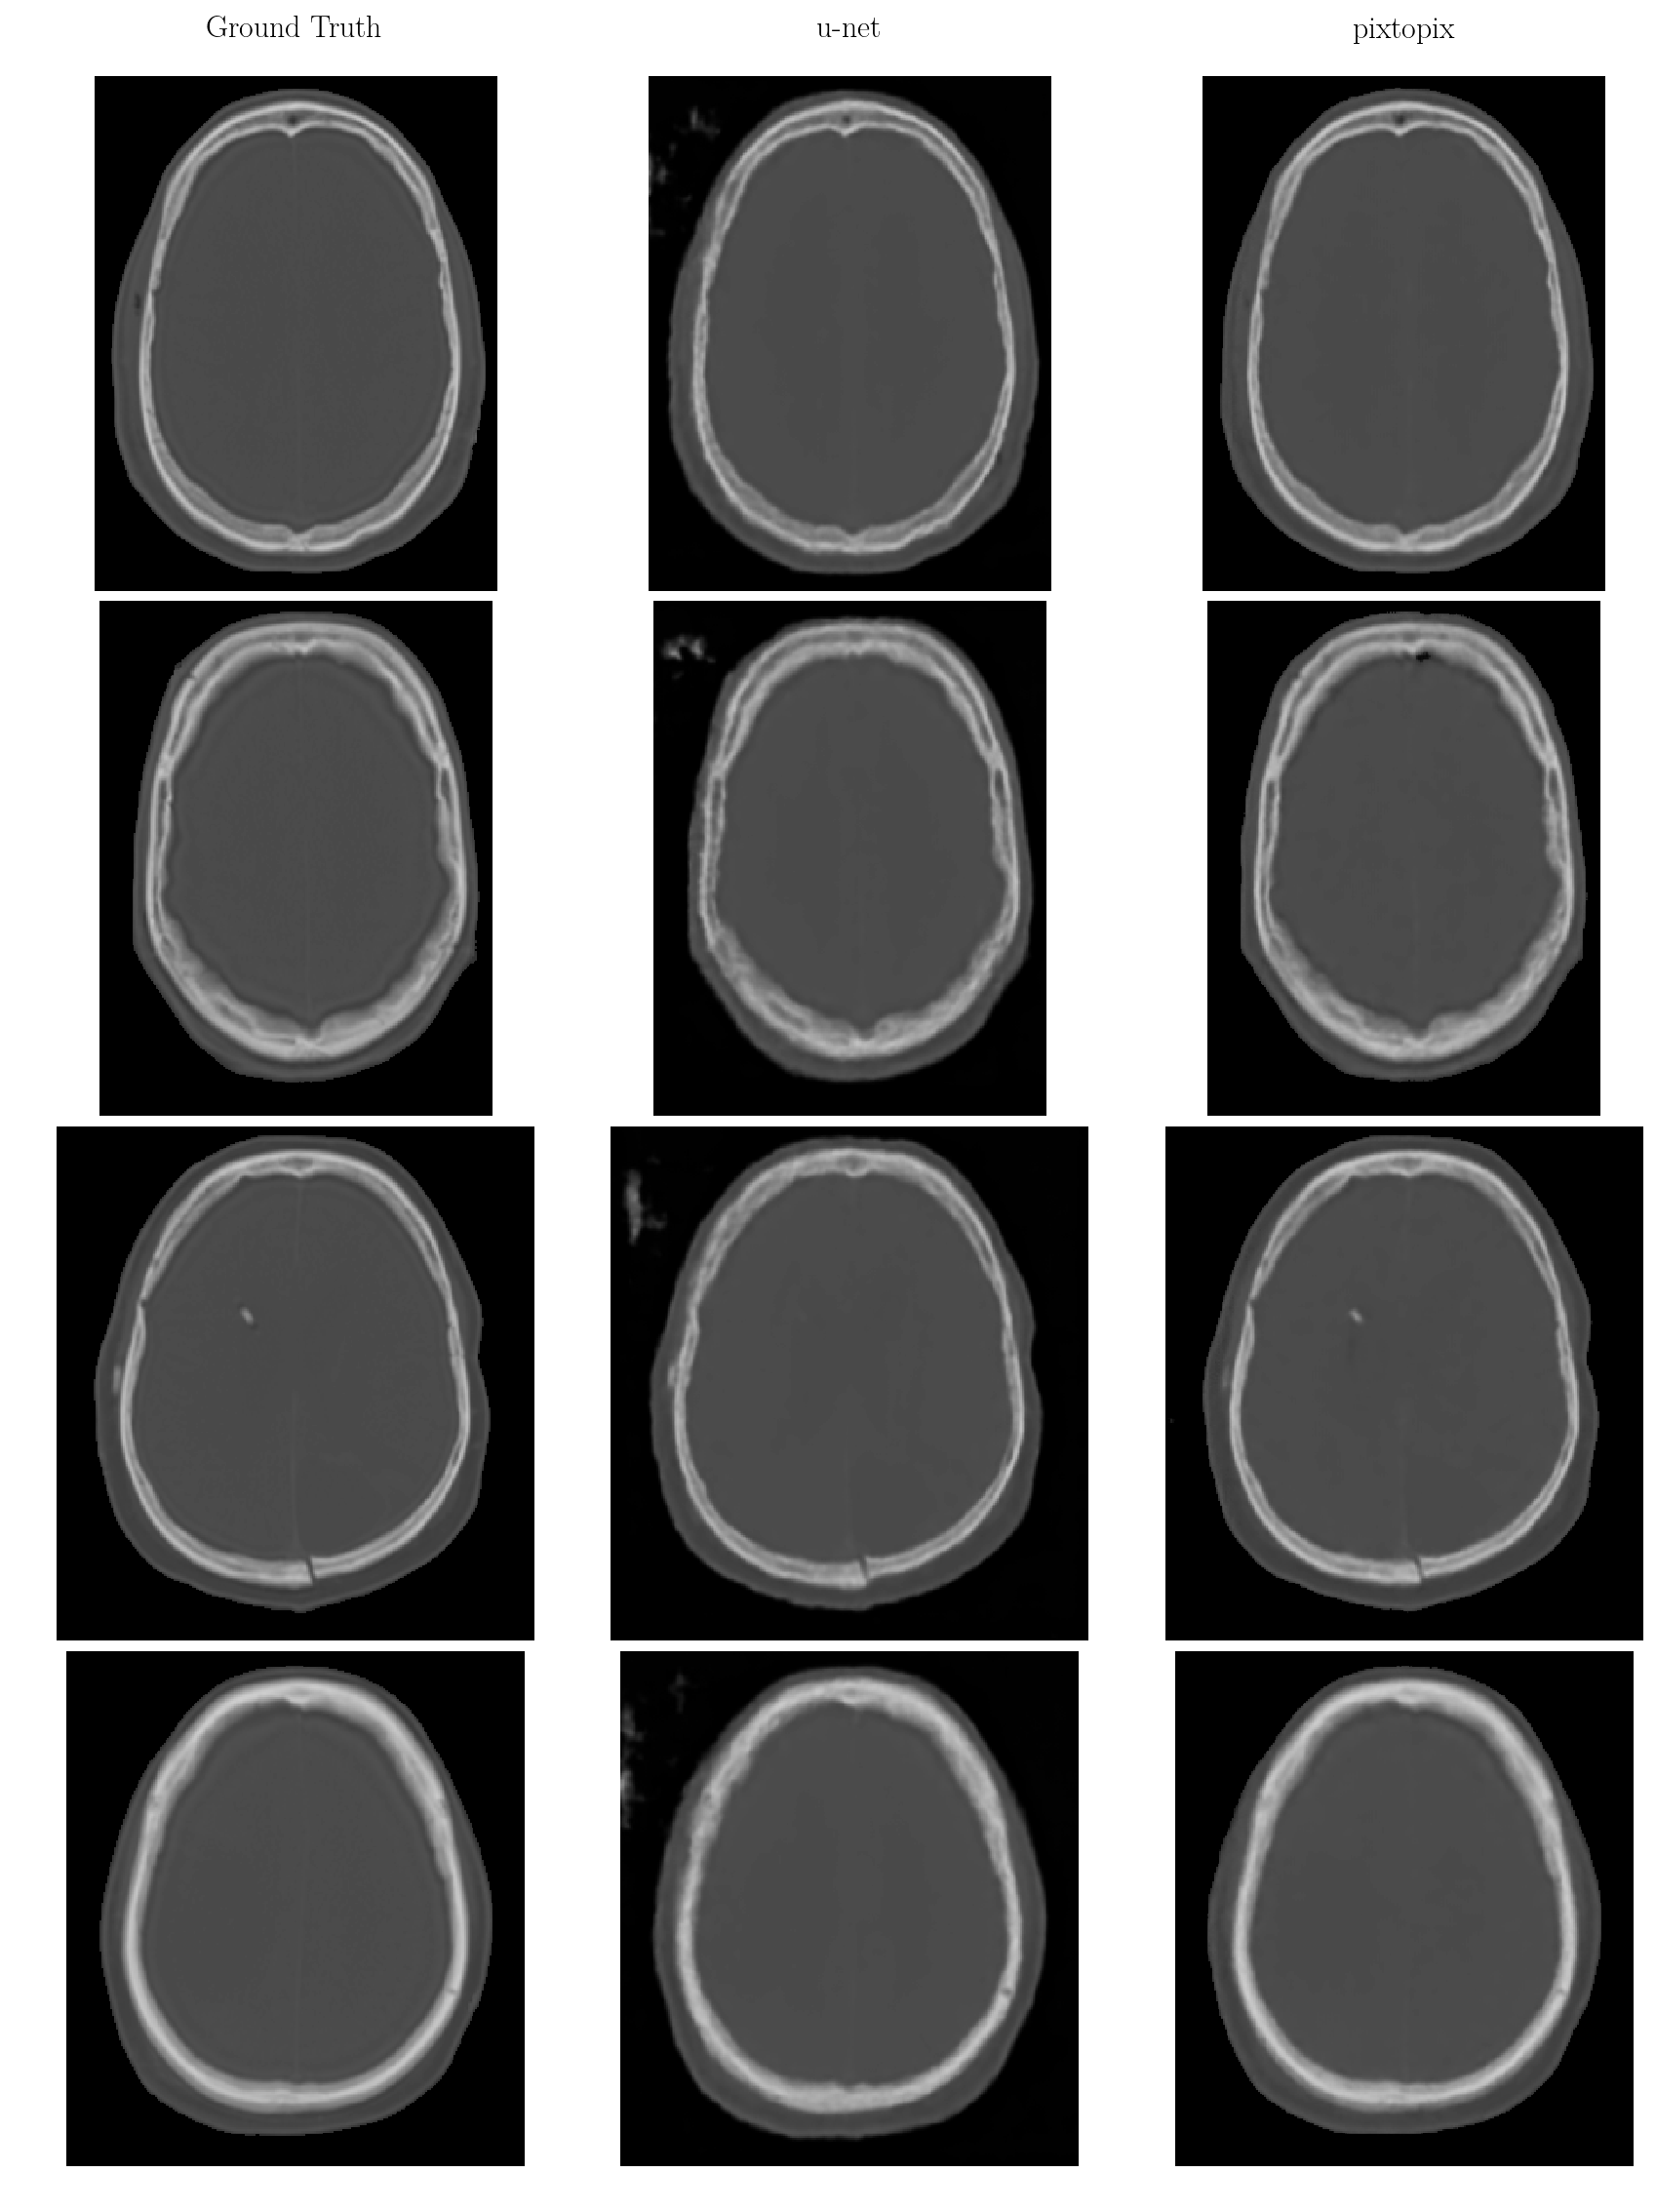

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 16))

vmin = np.min([vols[1].min() for vols in t])
vmax = np.max([vols[1].max() for vols in t])

axes[0][0].set_title('Ground Truth')
axes[0][1].set_title('u-net')
axes[0][2].set_title('pixtopix')

for i in range(4):
    for j in [10, 20, 30, 40]:
        axes[i][0].imshow(t[i][1][j, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i][1].imshow(t[i][2][j, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i][2].imshow(t[i][3][j, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

        axes[i][0].set_axis_off()
        axes[i][1].set_axis_off()
        axes[i][2].set_axis_off()

plt.subplots_adjust(top=.94, hspace=.02, wspace=.02, bottom=0.01, left=0.01, right=0.99)
plt.savefig('../mrtoct-article/figure/unet-pixtopix-training.pgf')
#plt.savefig('../mrtoct-article/figure/unet-pixtopix-training.pdf')
plt.show()

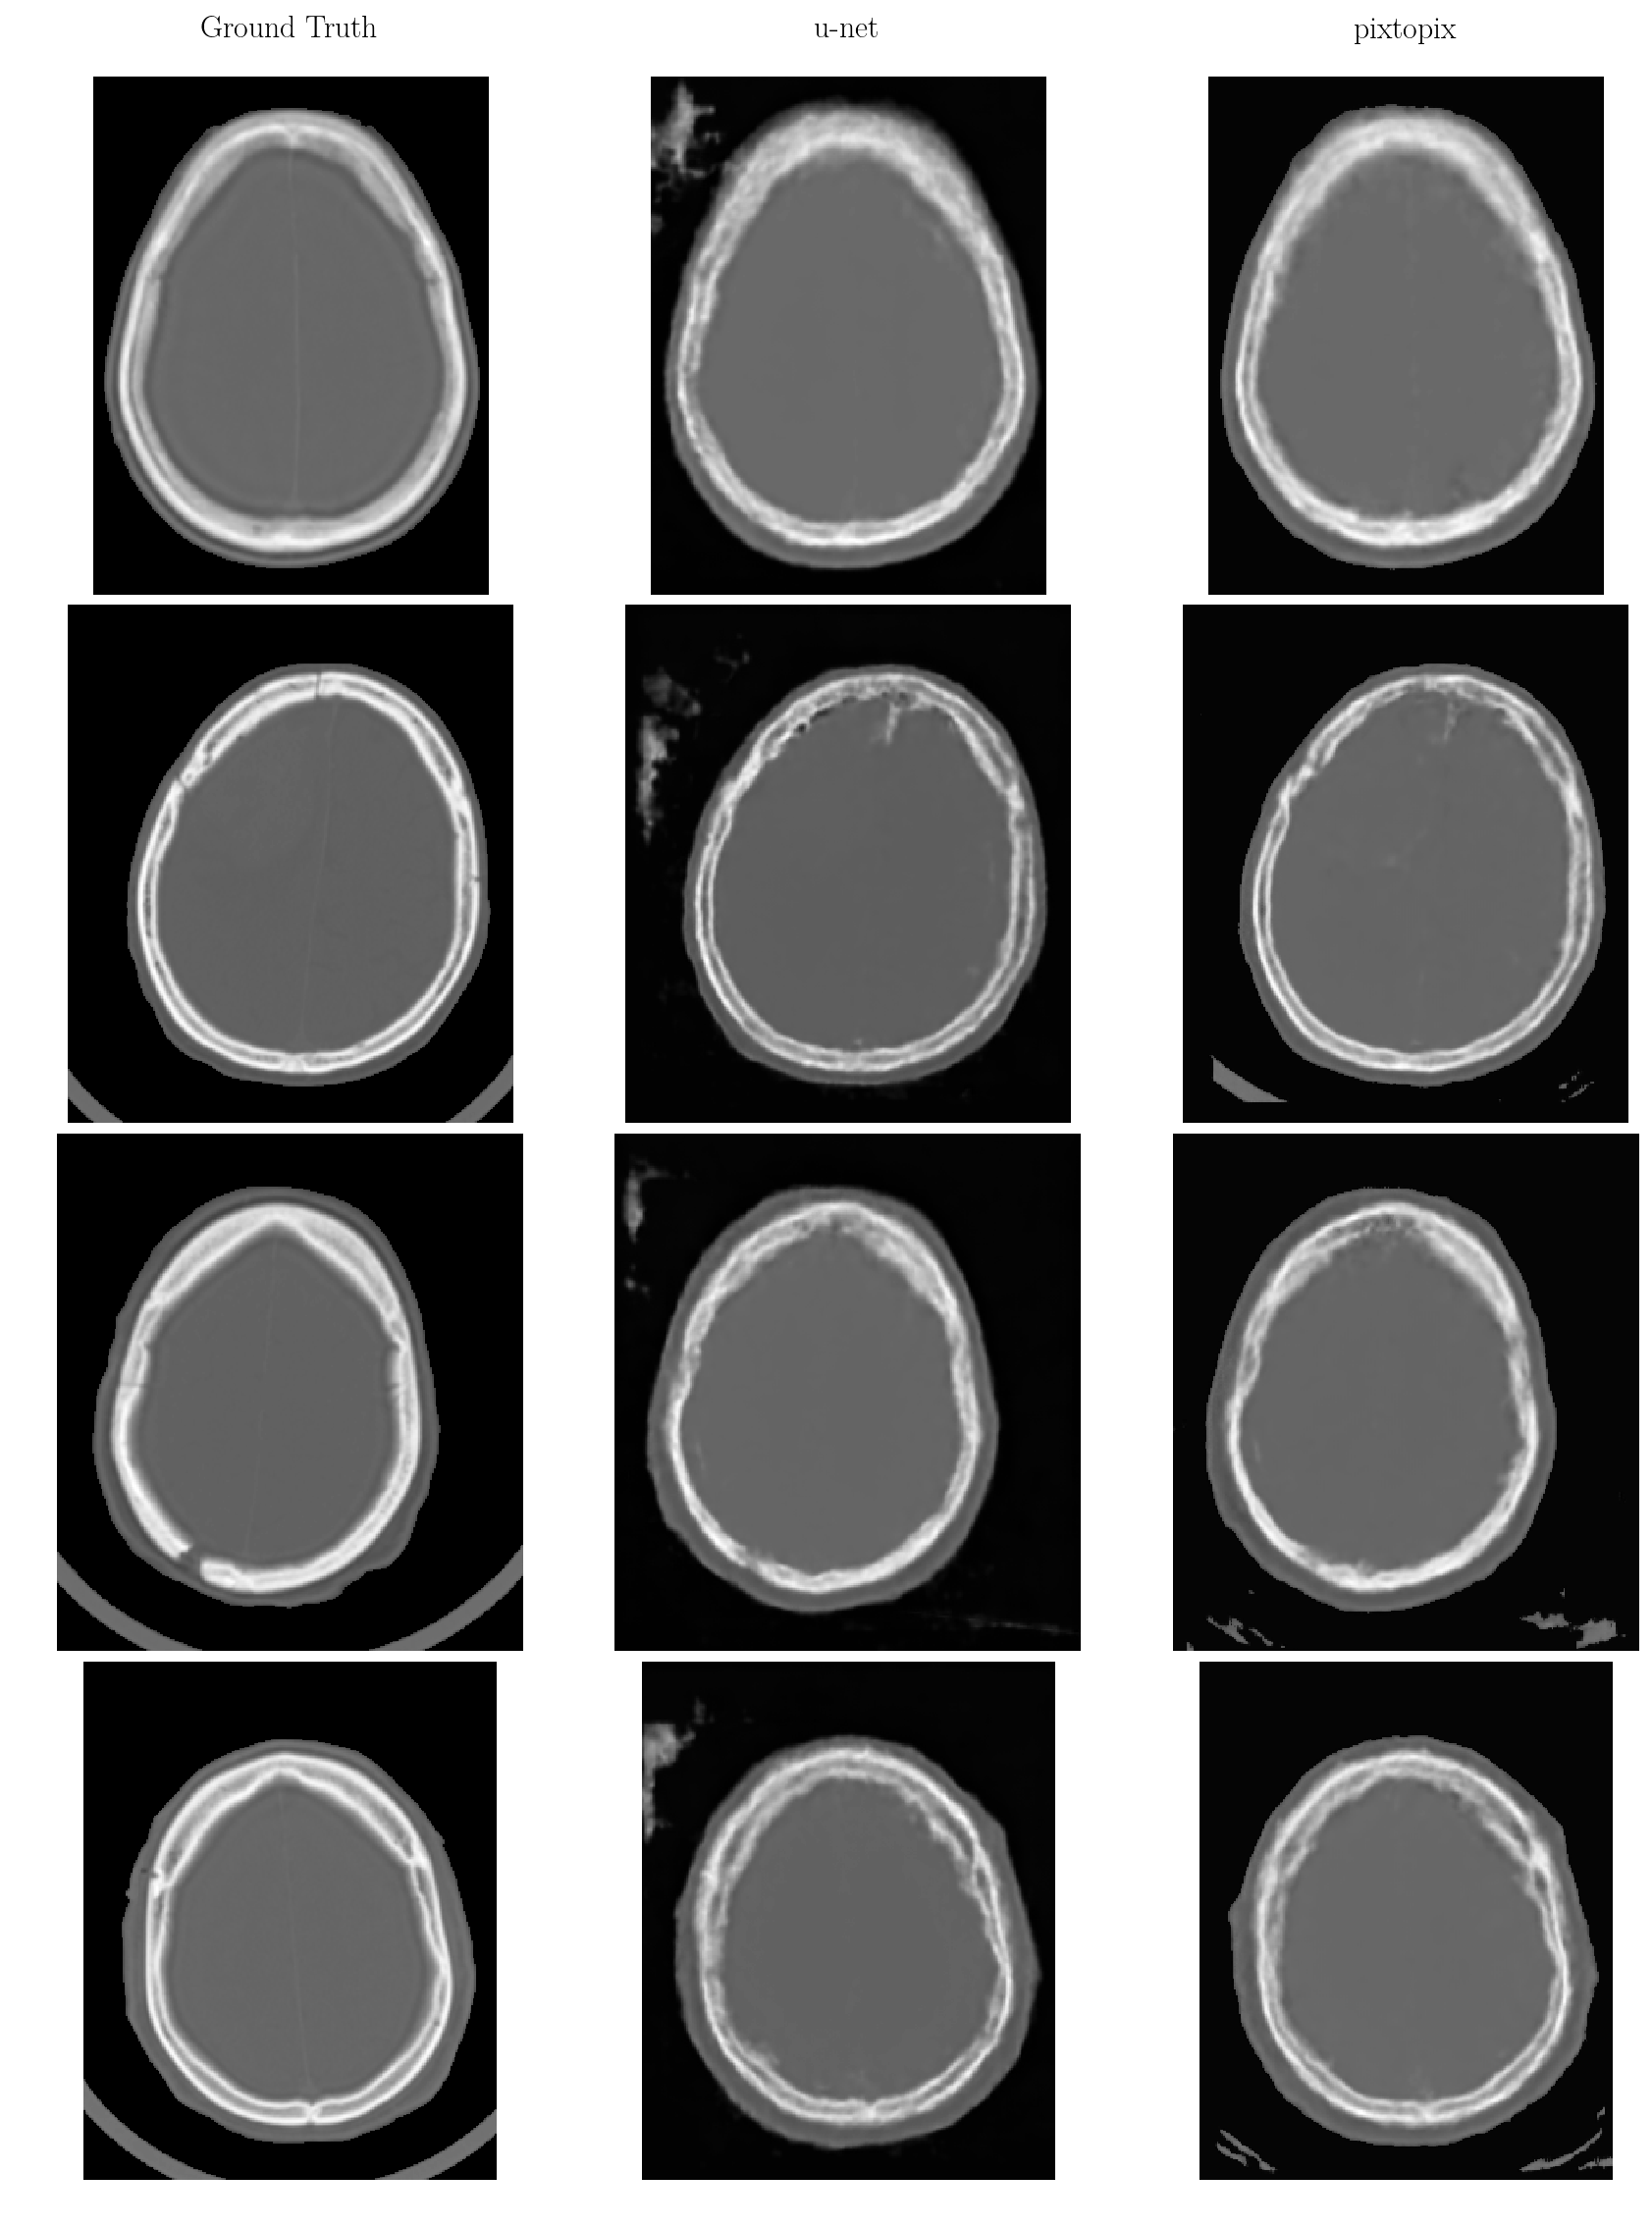

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 16))

vmin = np.min([vols[1].min() for vols in t])
vmax = np.max([vols[1].max() for vols in t])

axes[0][0].set_title('Ground Truth')
axes[0][1].set_title('u-net')
axes[0][2].set_title('pixtopix')

for i, k in enumerate([0, 1, 2, 3]):
    for j in [10, 20, 30, 40]:
        axes[i][0].imshow(v[k][1][j, :, :, 0], cmap='gray')#, aspect='auto')#, vmin=vmin, vmax=vmax)
        axes[i][1].imshow(v[k][2][j, :, :, 0], cmap='gray')#, aspect='auto')#, vmin=vmin, vmax=vmax)
        axes[i][2].imshow(v[k][3][j, :, :, 0], cmap='gray')#, aspect='auto')#, vmin=vmin, vmax=vmax)
        
        axes[i][0].set_axis_off()
        axes[i][1].set_axis_off()
        axes[i][2].set_axis_off()

plt.subplots_adjust(top=.94, hspace=.02, wspace=.02, bottom=0.01, left=0.01, right=0.99)
plt.savefig('../mrtoct-article/figure/unet-pixtopix-validation.pgf')
#plt.savefig('../mrtoct-article/figure/unet-pixtopix-validation.pdf')
plt.show()

In [48]:
sum([t[i][1].shape[0] for i in range(len(t))])

2020

In [49]:
[t[i][1].shape for i in range(len(t))]

[(137, 320, 250, 1),
 (130, 328, 250, 1),
 (111, 303, 281, 1),
 (143, 291, 259, 1),
 (141, 307, 284, 1),
 (148, 278, 267, 1),
 (198, 289, 268, 1),
 (208, 282, 238, 1),
 (162, 322, 252, 1),
 (185, 303, 243, 1),
 (180, 317, 239, 1),
 (184, 310, 248, 1),
 (93, 313, 238, 1)]

In [50]:
[v[i][1].shape for i in range(len(v))]

[(105, 298, 227, 1),
 (190, 328, 282, 1),
 (202, 307, 276, 1),
 (198, 329, 262, 1)]